In [2]:
import glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math as m
%matplotlib inline

plt.style.use('ggplot')

path = r'/data/developer/python'    
allFiles = glob.glob(path + "/SQL*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)-([0-9]*)', file_)
    df = pd.read_csv(file_,sep = '@',names = ['stmt_hash','query','exec_time'])
    df['date'] = regex.group(1)
    df['hour'] = regex.group(2)
    df.exec_time = pd.to_numeric(df.exec_time,errors='coerce')
    df.hour = pd.to_numeric(df.hour,errors='coerce')
    list_.append(df)
data = pd.concat(list_,ignore_index=True)

In [5]:
data['logexectime'] = 0
for i in range (0,len(data)):
    if data.loc[i,('exec_time')] > 0:        
       data.loc[i,('logexectime')] = m.log10(data.loc[i,('exec_time')])
#        data.loc[0,('logexectime')] = m.log10(data.loc[0,('exec_time')])
print(data.loc[0,('logexectime')])

1.82445127004


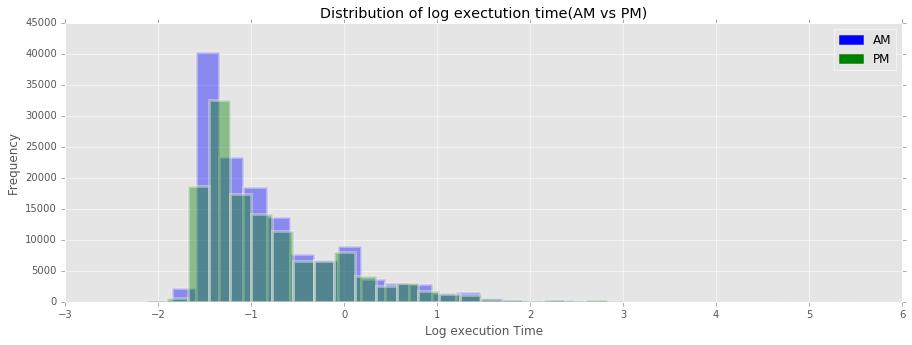

In [6]:
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='b', label='AM')
green_patch = mpatches.Patch(color='g', label='PM')
morning_data = data[data.hour<12]
evening_data = data[data.hour>12]
fig,axes = plt.subplots(1,1,figsize=(15,5))
axes.legend(handles=[blue_patch,green_patch])
axes.set_xlabel('Log execution Time')
axes.set_ylabel('Frequency')
axes.hist([morning_data[morning_data.exec_time>0].logexectime],bins=30, lw=3, color= 'b',alpha=0.4)
axes.hist([evening_data[evening_data.exec_time>0].logexectime],bins=30, lw=3, color= 'g',alpha=0.4)
axes.set_title("Distribution of log exectution time(AM vs PM)")

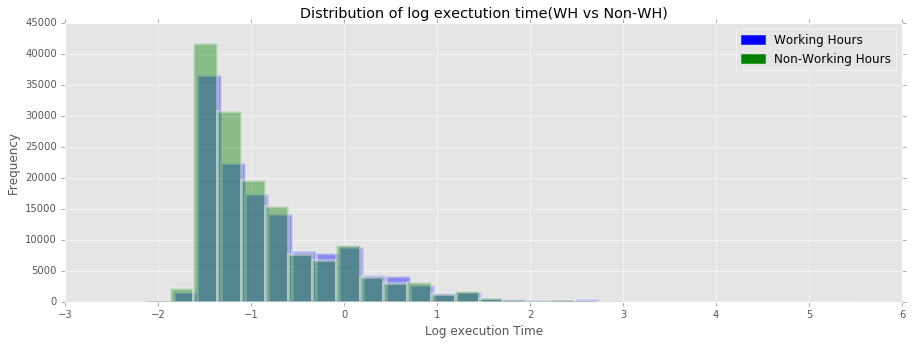

In [7]:
wh_data = data[(data.hour>8) & (data.hour<18)]
nwh_data = data[~((data.hour>8) & (data.hour<18))]
blue_patch = mpatches.Patch(color='b', label='Working Hours')
green_patch = mpatches.Patch(color='g', label='Non-Working Hours')
fig,axes = plt.subplots(1,1,figsize=(15,5))
axes.legend(handles=[blue_patch,green_patch])
axes.set_xlabel('Log execution Time')
axes.set_ylabel('Frequency')
axes.hist([wh_data[wh_data.exec_time>0].logexectime],bins=30, lw=3, color= 'b',alpha=0.4)
axes.hist([nwh_data[nwh_data.exec_time>0].logexectime],bins=30, lw=3, color= 'g',alpha=0.4)
axes.set_title("Distribution of log exectution time(WH vs Non-WH)")

In [8]:
fields = ['time','lock_wait_time','total_section_sort_time','diaglog_write_wait_time','direct_read_time','direct_write_time','log_buffer_wait_time','log_disk_wait_time','pool_read_time','pool_write_time','prefetch_wait_time','total_act_time','total_act_wait_time','total_cpu_time','total_extended_latch_wait_time','span']
wldf = pd.read_csv('/data/developer/python/workload_stats.csv',sep = '@',names = fields,index_col=False)

In [9]:
wldf['hour'] = 0
wldf['date'] = 0
for i in range (0,len(wldf)):
    regex = re.search('([0-9-]*)T([0-9]*)', wldf.loc[i,('time')])
    hour_int = int(regex.group(2)) + 1 
    wldf.loc[i,('date')] = regex.group(1)
    wldf.loc[i,('hour')] = hour_int

In [10]:
merge_data = data.merge(wldf, left_on=['date','hour'], right_on=['date','hour'], how='inner')

In [219]:
import sqlparse as sp
import numpy as np
merge_data['stmttype'] = 0
merge_data['numfields'] = 0
merge_data['numtables'] = 0

#Parse SQL
merge_data.query=merge_data['query'].apply(np.frompyfunc(lambda x : sp.parse(x),1,1))

#populate stmttype
for i in range (0,len(merge_data)):
    merge_data.loc[i,('stmttype')] = merge_data.query[i].get_type()
    i = i + 1

#populate numfields
for i in range (0,len(merge_data)):
    parsed_query = [t.to_unicode() for t in merge_data.query[i].tokens if t.ttype is None]
    if (len(parsed_query) > 0):
         if (merge_data.query[i].get_type() == 'SELECT'):
            merge_data.loc[i,('numfields')] = len(parsed_query[0].split(','))
         if (merge_data.query[i].get_type() == 'INSERT'):
            if (len(parsed_query[0].split('(')) > 1):
                merge_data.loc[i,('numfields')] = len(parsed_query[0].split('(')[1].split(','))
            else:
                merge_data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (merge_data.query[i].get_type() == 'UPDATE'):
            merge_data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (merge_data.query[i].get_type() == 'DELETE'):
            merge_data.loc[i,('numfields')] = 0
    i = i + 1

#populate numtables
for i in range (0,len(merge_data)):
    if (len(parsed_query) > 1):
        if (merge_data.query[i].get_type() == 'SELECT'):
            numtables = 0
            splitjoin = merge_data.query[i].to_unicode().upper().split(' JOIN ')
            for setoftables in splitjoin:
                splitfrom = setoftables.split(' FROM ')
                numtables = numtables + len(splitfrom[len(splitfrom)-1].split(' WHERE ')[0].split(')')[0].split(','))
            merge_data.loc[i,('numtables')] = numtables
        else:
            merge_data.loc[i,('numtables')] = 1
    else:
        merge_data.loc[i,('numtables')] = 1
    i = i + 1


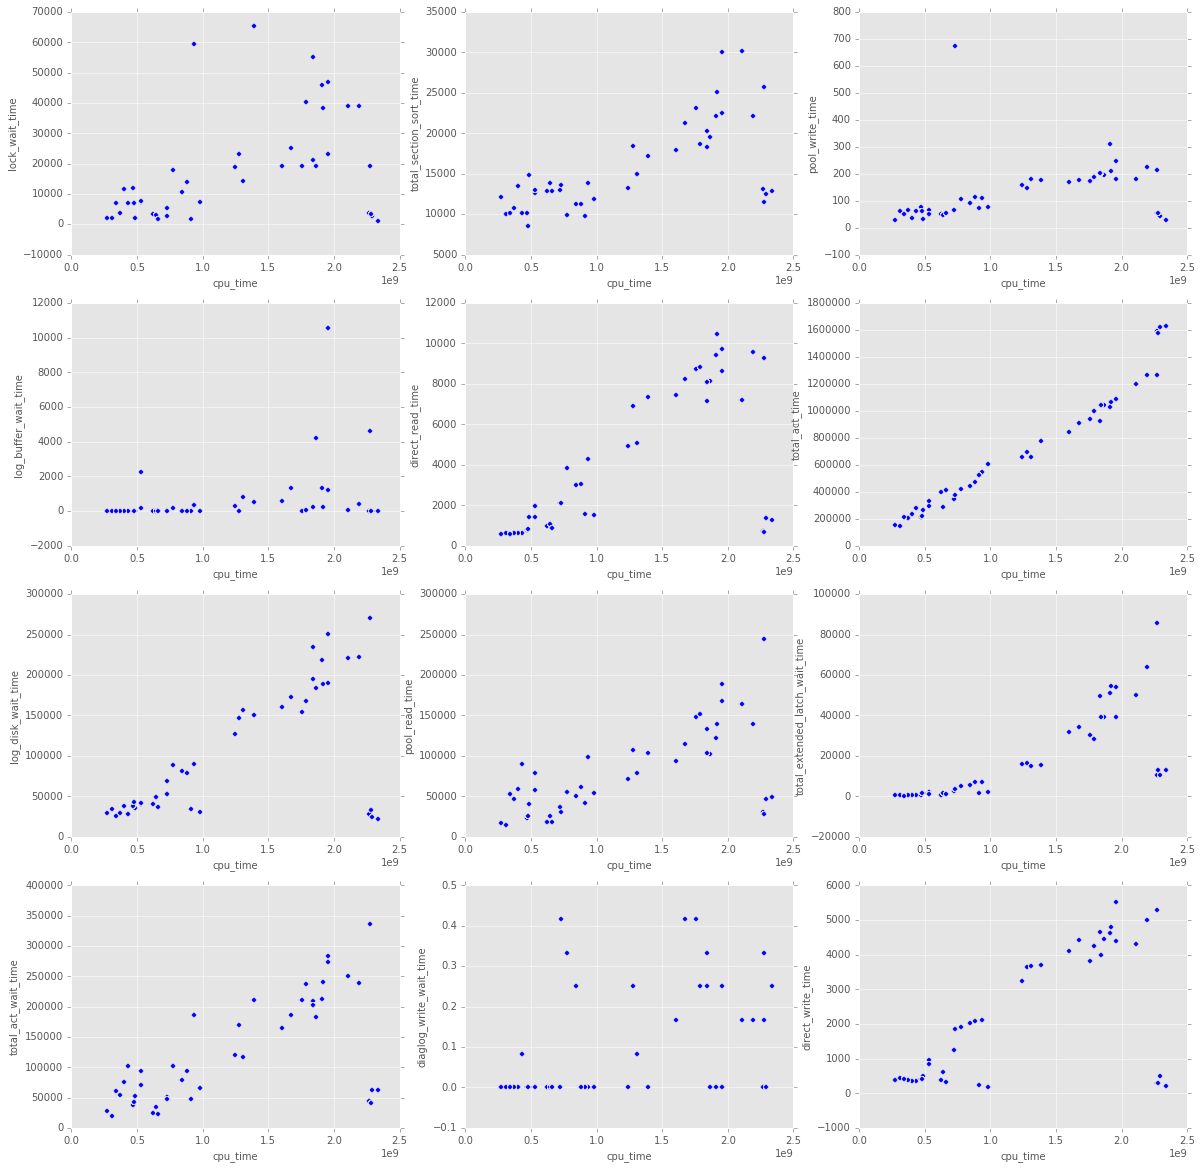

In [11]:
fig,axes = plt.subplots(4,3,figsize = (20,20))
axes[0][0].set_xlabel('cpu_time' , fontsize=10)
axes[0][0].set_ylabel('lock_wait_time' , fontsize=10)
axes[0][0].scatter(merge_data.total_cpu_time,merge_data.lock_wait_time)

axes[0][1].set_xlabel('cpu_time' , fontsize=10)
axes[0][1].set_ylabel('total_section_sort_time' , fontsize=10)
axes[0][1].scatter(merge_data.total_cpu_time,merge_data.total_section_sort_time)

axes[0][2].set_xlabel('cpu_time' , fontsize=10)
axes[0][2].set_ylabel('pool_write_time' , fontsize=10)
axes[0][2].scatter(merge_data.total_cpu_time,merge_data.pool_write_time)


axes[1][0].set_xlabel('cpu_time' , fontsize=10)
axes[1][0].set_ylabel('log_buffer_wait_time' , fontsize=10)
axes[1][0].scatter(merge_data.total_cpu_time,merge_data.log_buffer_wait_time)

axes[1][1].set_xlabel('cpu_time' , fontsize=10)
axes[1][1].set_ylabel('direct_read_time' , fontsize=10)
axes[1][1].scatter(merge_data.total_cpu_time,merge_data.direct_read_time)

axes[1][2].set_xlabel('cpu_time' , fontsize=10)
axes[1][2].set_ylabel('total_act_time' , fontsize=10)
axes[1][2].scatter(merge_data.total_cpu_time,merge_data.total_act_time)


axes[2][0].set_xlabel('cpu_time' , fontsize=10)
axes[2][0].set_ylabel('log_disk_wait_time' , fontsize=10)
axes[2][0].scatter(merge_data.total_cpu_time,merge_data.log_disk_wait_time)

axes[2][1].set_xlabel('cpu_time' , fontsize=10)
axes[2][1].set_ylabel('pool_read_time' , fontsize=10)
axes[2][1].scatter(merge_data.total_cpu_time,merge_data.pool_read_time)

axes[2][2].set_xlabel('cpu_time' , fontsize=10)
axes[2][2].set_ylabel('total_extended_latch_wait_time' , fontsize=10)
axes[2][2].scatter(merge_data.total_cpu_time,merge_data.total_extended_latch_wait_time)

axes[3][0].set_xlabel('cpu_time' , fontsize=10)
axes[3][0].set_ylabel('total_act_wait_time' , fontsize=10)
axes[3][0].scatter(merge_data.total_cpu_time,merge_data.total_act_wait_time)

axes[3][1].set_xlabel('cpu_time' , fontsize=10)
axes[3][1].set_ylabel('diaglog_write_wait_time' , fontsize=10)
axes[3][1].scatter(merge_data.total_cpu_time,merge_data.diaglog_write_wait_time)

axes[3][2].set_xlabel('cpu_time' , fontsize=10)
axes[3][2].set_ylabel('direct_write_time' , fontsize=10)
axes[3][2].scatter(merge_data.total_cpu_time,merge_data.direct_write_time)




In [12]:
merge_data['logexectime'] = 0
for i in range (0,len(merge_data)):
    if merge_data.loc[i,('exec_time')] > 0:
        merge_data.loc[i,('logexectime')] = m.log10(merge_data.loc[i,('exec_time')])

In [13]:
merge_data['logcputime'] = 0
for i in range (0,len(merge_data)):
    if merge_data.loc[i,('logcputime')] > 0:
        merge_data.loc[i,('logcputime')] = m.log10(merge_data.loc[i,('cpu_time')])

In [16]:
merge_data['log_total_section_sort_time'] = 0
for i in range (0,len(merge_data)):
    if merge_data.loc[i,('log_total_section_sort_time')] > 0:
        merge_data.loc[i,('log_total_section_sort_time')] = m.log10(merge_data.loc[i,('total_section_sort_time')])

In [14]:
merge_data['log_lock_wait_time'] = 0
for i in range (0,len(merge_data)):
    if merge_data.loc[i,('log_lock_wait_time')] > 0:
        merge_data.loc[i,('log_lock_wait_time')] = m.log10(merge_data.loc[i,('lock_wait_time')])

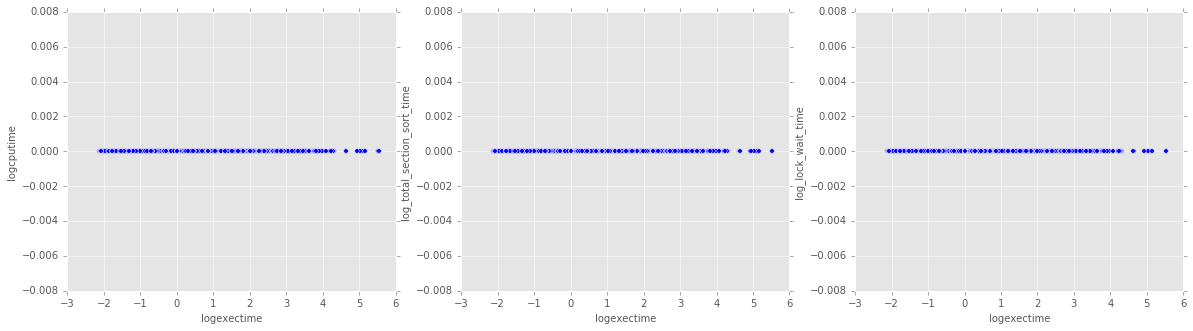

In [31]:
fig,axes = plt.subplots(1,3,figsize = (20,5))
axes[0].set_xlabel('logexectime' , fontsize=10)
axes[0].set_ylabel('logcputime' , fontsize=10)
axes[0].scatter(merge_data.logexectime,merge_data.logcputime)

axes[1].set_xlabel('logexectime' , fontsize=10)
axes[1].set_ylabel('log_total_section_sort_time' , fontsize=10)
axes[1].scatter(merge_data.logexectime,merge_data.log_total_section_sort_time)

axes[2].set_xlabel('logexectime' , fontsize=10)
axes[2].set_ylabel('log_lock_wait_time' , fontsize=10)
axes[2].scatter(merge_data.logexectime,merge_data.log_lock_wait_time)


In [27]:
merge_data.log_lock_wait_time.head()

0    0
1    0
2    0
3    0
4    0
Name: log_lock_wait_time, dtype: int64